# Prepare

In [1]:
import math
import re
import os
import string
import random
from collections import Counter, OrderedDict
from functools import lru_cache
from pprint import pprint


import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pyarabic.araby as araby
from beautifultable import BeautifulTable
from datasets import Dataset, load_dataset
from scipy.stats import linregress
from tqdm.auto import tqdm

In [2]:
random.seed(42)

In [3]:
%cd ../../..

/home/majed_alshaibani/Experiments/DotlessArabic


In [4]:
from dotless_arabic.datasets.utils import calculate_entropy
from dotless_arabic.processing import process, undot
from dotless_arabic.datasets.wikipedia.collect import collect_dataset_for_analysis as collect_wikipedia_dataset

In [5]:
ENGLISH_LETTERS = string.ascii_lowercase

In [6]:
def process_english(text):
    # add spaces between punctuations, if there is not
    text = text.lower()
    text = re.sub(
        r"""([.,!?()\/\\،"'\{\}\(\)\[\]؟<>`؛=+\-\*\&\^\%\$\#\@\!])""",
        r" \1 ",
        text,
    )
    # remove any non arabic character
    text = "".join(
        [c for c in text if c in ENGLISH_LETTERS or c.isspace()]
    )  # keep only english chars and spaces
    text = re.sub("\s{2,}", " ", text).strip()  # remove multiple spaces
    """
      interestingly, there is a difference betwen re.sub('\s+',' ',s) and re.sub('\s{2,}',' ',s)
      the first one remove newlines while the second does not.
    """
    return text.strip()

In [7]:
ar_wikipedia = collect_wikipedia_dataset()
ar_wiki = list(map(process,tqdm(ar_wikipedia)))
ar_wiki = list(filter(lambda item: len(item.strip())>0,tqdm(ar_wiki)))
len(ar_wiki)

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

4591846

In [8]:
undotted_ar_wiki = list(map(undot,tqdm(ar_wiki)))
len(undotted_ar_wiki)

  0%|          | 0/4591846 [00:00<?, ?it/s]

4591846

In [9]:
en_hf_wikipedia_dataset = Dataset.from_json("../enwiki/**/wiki_*")
en_hf_wikipedia_dataset = en_hf_wikipedia_dataset.filter(
    lambda article: article["text"]
)


def wikipedia_hf_process_en(item):
    item["processed_text"] = process_english(item["text"])
    return item


en_hf_wikipedia_dataset = en_hf_wikipedia_dataset.map(
    wikipedia_hf_process_en,
    num_proc=os.cpu_count(),
)
en_wiki = list(en_hf_wikipedia_dataset['processed_text'][:125_000])
en_wiki = list(filter(lambda item: len(item.strip())>0,tqdm(en_wiki)))
len(en_wiki)

Resolving data files:   0%|          | 0/17144 [00:00<?, ?it/s]

Found cached dataset json (/home/majed_alshaibani/.cache/huggingface/datasets/json/default-2968a511baae7e5d/0.0.0)
Loading cached processed dataset at /home/majed_alshaibani/.cache/huggingface/datasets/json/default-2968a511baae7e5d/0.0.0/cache-841adf3f6f6ca163.arrow
Loading cached processed dataset at /home/majed_alshaibani/.cache/huggingface/datasets/json/default-2968a511baae7e5d/0.0.0/cache-4749db41d3af6261_*_of_00032.arrow


  0%|          | 0/125000 [00:00<?, ?it/s]

124967

In [10]:
random.shuffle(en_wiki)
random.shuffle(ar_wiki)
random.shuffle(undotted_ar_wiki)

# Functions

In [11]:
@lru_cache()
def characters_counter(dataset, use_tqdm=True):
    dataset = tqdm(dataset) if use_tqdm else dataset
    return Counter(character for item in dataset for word in item.split() for character in word)


@lru_cache()
def words_counter(dataset, use_tqdm=True):
    dataset = tqdm(dataset) if use_tqdm else dataset
    return Counter(word for item in dataset for word in item.split())


def characters_analysis(dataset, print_counter=False):
    counter = characters_counter(tuple(dataset))
    if print_counter:
        pprint(counter)
    unique_characters_count = len(counter.keys())
    print("unique characters count:", f"{unique_characters_count:,}")
    return unique_characters_count


def words_analysis(dataset, top_freq=100):
    counter = words_counter(tuple(dataset))
    words_count = sum(counter.values())
    unique_words_count = len(counter.keys())
    counter = OrderedDict(counter.most_common(top_freq))
    pprint(counter)
    print("words count:", f"{words_count:,}")
    return unique_words_count


def characters_entropy(dataset):
    counter = characters_counter(tuple(dataset))
    return calculate_entropy(counter)


def words_entropy(dataset):
    counter = words_counter(tuple(dataset))
    return calculate_entropy(counter)

In [12]:
# we may need to report the error on the regression line: MSE, MAE, etc.
@lru_cache()
def get_heaps_law_constants(dataset, get_points_list=False, clear_lru_cache=False):
    X, Y = [], []
    vocabulary = set()
    number_of_tokens = 0
    for index in tqdm(range(len(dataset))):
        counter = words_counter(
            tuple([dataset[index]]),
            use_tqdm=False,
        )
        
        number_of_tokens += sum(counter.values())
        
        X.append(
            math.log(
                number_of_tokens,
                math.e,  # base
            ),
        )
        
        vocabulary.update(counter.keys())
        
        Y.append(
            math.log(
                len(vocabulary),
                math.e,  # base
            ),
        )

        if clear_lru_cache:
            words_counter.cache_clear()

    slope, intercept, *_ = linregress(X, Y)

    b = slope
    k = math.e**intercept

    if get_points_list:
        return b, k, (X, Y)
    return b, k

In [13]:
def get_zipf_constants(counter):
    heighest_frequency = counter.most_common(1)[-1][1]
    X = np.log(heighest_frequency) * np.log((np.arange(len(counter)) + 1))
    Y = np.log(np.array(list(counter.values())))
    slope, intercept, *_ = linregress(X, Y)
    return np.exp(slope), np.exp(intercept)

# Show

In [14]:
# english wiki

english_wiki_unique_characters = len(characters_counter(dataset=tuple(en_wiki)).keys())
english_wiki_all_characters = sum(characters_counter(dataset=tuple(en_wiki)).values())
english_wiki_characters_entropy = characters_entropy(dataset=tuple(en_wiki))

english_wiki_unique_words = len(words_counter(dataset=tuple(en_wiki)).keys())
english_wiki_all_words = sum(words_counter(dataset=tuple(en_wiki)).values())
english_wiki_words_entropy = words_entropy(dataset=tuple(en_wiki))

english_wiki_heaps_beta,english_wiki_heaps_k,(english_wiki_heaps_X,english_wiki_heaps_Y) = get_heaps_law_constants(dataset=tuple(en_wiki),get_points_list=True)


# arabic wiki

arabic_wiki_unique_characters = len(characters_counter(dataset=tuple(ar_wiki)).keys())
arabic_wiki_all_characters = sum(characters_counter(dataset=tuple(ar_wiki)).values())
arabic_wiki_characters_entropy = characters_entropy(dataset=tuple(ar_wiki))

arabic_wiki_unique_words = len(words_counter(dataset=tuple(ar_wiki)).keys())
arabic_wiki_all_words = sum(words_counter(dataset=tuple(ar_wiki)).values())
arabic_wiki_words_entropy = words_entropy(dataset=tuple(ar_wiki))

arabic_wiki_heaps_beta,arabic_wiki_heaps_k,(arabic_wiki_heaps_X,arabic_wiki_heaps_Y) = get_heaps_law_constants(dataset=tuple(ar_wiki),get_points_list=True)


# undotted arabic wiki

undotted_arabic_wiki_unique_characters = len(characters_counter(dataset=tuple(undotted_ar_wiki)).keys())
undotted_arabic_wiki_all_characters = sum(characters_counter(dataset=tuple(undotted_ar_wiki)).values())
undotted_arabic_wiki_characters_entropy = characters_entropy(dataset=tuple(undotted_ar_wiki))

undotted_arabic_wiki_unique_words = len(words_counter(dataset=tuple(undotted_ar_wiki)).keys())
undotted_arabic_wiki_all_words = sum(words_counter(dataset=tuple(undotted_ar_wiki)).values())
undotted_arabic_wiki_words_entropy = words_entropy(dataset=tuple(undotted_ar_wiki))

undotted_arabic_wiki_heaps_beta,undotted_arabic_wiki_heaps_k,(undotted_arabic_wiki_heaps_X,undotted_arabic_wiki_heaps_Y) = get_heaps_law_constants(dataset=tuple(undotted_ar_wiki),get_points_list=True)


  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

In [15]:
chars_analysis_table = BeautifulTable(maxwidth=300)
chars_analysis_table.columns.header = [
    'dataset',
    'unique \n chars',
    'all \n chars',
    'chars \n entropy',
    'unique \n words (V)',
    'all \n words (N)',
    'words \n entropy',
    'Heaps law \n (b,k) constants',
    ]
chars_analysis_table.rows.append([
      'english wiki',
      f'{english_wiki_unique_characters:,}',
      f'{english_wiki_all_characters:,}',
      f'{english_wiki_characters_entropy:,}',
      f'{english_wiki_unique_words:,}',
      f'{english_wiki_all_words:,}',
      f'{english_wiki_words_entropy:,}',
      f'({english_wiki_heaps_beta:.3f},{english_wiki_heaps_k:.3f})',
  ]
)
chars_analysis_table.rows.append([
      'arabic wiki',
      f'{arabic_wiki_unique_characters:,}',
      f'{arabic_wiki_all_characters:,}',
      f'{arabic_wiki_characters_entropy:,}',
      f'{arabic_wiki_unique_words:,}',
      f'{arabic_wiki_all_words:,}',
      f'{arabic_wiki_words_entropy:,}',
      f'({arabic_wiki_heaps_beta:.3f},{arabic_wiki_heaps_k:.3f})',
  ]
)

chars_analysis_table.rows.append([
      'undotted arabic wiki',
      f'{undotted_arabic_wiki_unique_characters:,}',
      f'{undotted_arabic_wiki_all_characters:,}',
      f'{undotted_arabic_wiki_characters_entropy:,}',
      f'{undotted_arabic_wiki_unique_words:,}',
      f'{undotted_arabic_wiki_all_words:,}',
      f'{undotted_arabic_wiki_words_entropy:,}',
      f'({undotted_arabic_wiki_heaps_beta:.3f},{undotted_arabic_wiki_heaps_k:.3f})',
  ]
)


print(chars_analysis_table)

+----------------------+---------+-------------+----------+------------+-------------+----------+------------------+
|       dataset        | unique  |    all      |  chars   |  unique    |    all      |  words   |    Heaps law     |
|                      |  chars  |    chars    |  entropy |  words (V) |  words (N)  |  entropy |  (b,k) constants |
+----------------------+---------+-------------+----------+------------+-------------+----------+------------------+
|     english wiki     |   26    | 981,135,548 |  4.173   | 1,019,960  | 198,029,572 |  10.968  |  (0.583,14.947)  |
+----------------------+---------+-------------+----------+------------+-------------+----------+------------------+
|     arabic wiki      |   31    | 851,699,872 |  4.274   | 1,811,244  | 177,422,512 |   13.2   |  (0.532,75.034)  |
+----------------------+---------+-------------+----------+------------+-------------+----------+------------------+
| undotted arabic wiki |   19    | 851,699,872 |  3.798   | 1,47

In [16]:
def plot_zipf(
    figsize=(25, 18),
    top_words=10_000_000,
    fontsize=15,
):
    # https://github.com/MagedSaeed/zipfs_law
    def _plot(counter, name, axis, log, linestyle=None):
        frequencies = [
            item[1]
            for item in sorted(counter.items(), key=lambda item: item[1], reverse=True)
        ][:top_words]
        ranks = [
            item + 1
            for item in range(
                len(sorted(counter.items(), key=lambda item: item[1], reverse=True))
            )
        ][:top_words]
        if linestyle is not None:
            axis.plot(ranks, frequencies, label=name, linestyle=linestyle)
        else:
            axis.plot(ranks, frequencies, label=name)

        if log:
            axis.set_xscale("log")
            axis.set_yscale("log")
            # axis.set_ylim(bottom=10**0)
            # axis.set_ylim(top=10**7.5)

        # add axis labels, title, and legend
        plt.xlabel("Rank", fontsize=fontsize)
        plt.ylabel("Frequency", fontsize=fontsize)
        title = "Frequency vs Rank for Words in a Text"
        if log:
            title = "Logorithmic " + title
        # axis.set_title(title)
        axis.legend(loc="upper right", fontsize=f"{fontsize}")

    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize,dpi=250)

    _plot(
        counter=words_counter(dataset=tuple(en_wiki)),
        name="english wikipedia dataset",
        axis=axis,
        log=True,
    )
    _plot(
        counter=words_counter(dataset=tuple(ar_wiki)),
        name="arabic wikipedia dataset",
        axis=axis,
        log=True,
    )
    _plot(
        counter=words_counter(dataset=tuple(undotted_ar_wiki)),
        name="undotted arabic wikipedia dataset",
        axis=axis,
        log=True,
    )
    
    heighest_frequency_ar = words_counter(dataset=tuple(ar_wiki)).most_common(1)[0][1]
    alpha_ar, c = get_zipf_constants(counter=words_counter(tuple(ar_wiki)))
    
    _plot(
        counter={
            rank: heighest_frequency_ar / (rank**alpha_ar)
            for rank, frequency in enumerate(
                sorted(
                    words_counter(dataset=tuple(ar_wiki)).values(),
                    reverse=True,
                ),
                start=1,
            )
        },
        name=f"standard zipfian distribution dotted arabic wikipedia (α={alpha_ar:.4f})",
        axis=axis,
        log=True,
        linestyle='dashed',
    )

    heighest_frequency_en = words_counter(dataset=tuple(en_wiki)).most_common(1)[0][1]
    alpha_en, c = get_zipf_constants(counter=words_counter(tuple(en_wiki)))
    
    _plot(
        counter={
            rank: heighest_frequency_ar / (rank**alpha_en)
            for rank, frequency in enumerate(
                sorted(
                    words_counter(dataset=tuple(en_wiki)).values(),
                    reverse=True,
                ),
                start=1,
            )
        },
        name=f"standard zipfian distribution dotted english un (α={alpha_en:.4f})",
        axis=axis,
        log=True,
        linestyle='dashed',
    )

    # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
    # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
    plt.rc("font", size=fontsize)

  0%|          | 0/124967 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/4591846 [00:00<?, ?it/s]

  0%|          | 0/124967 [00:00<?, ?it/s]

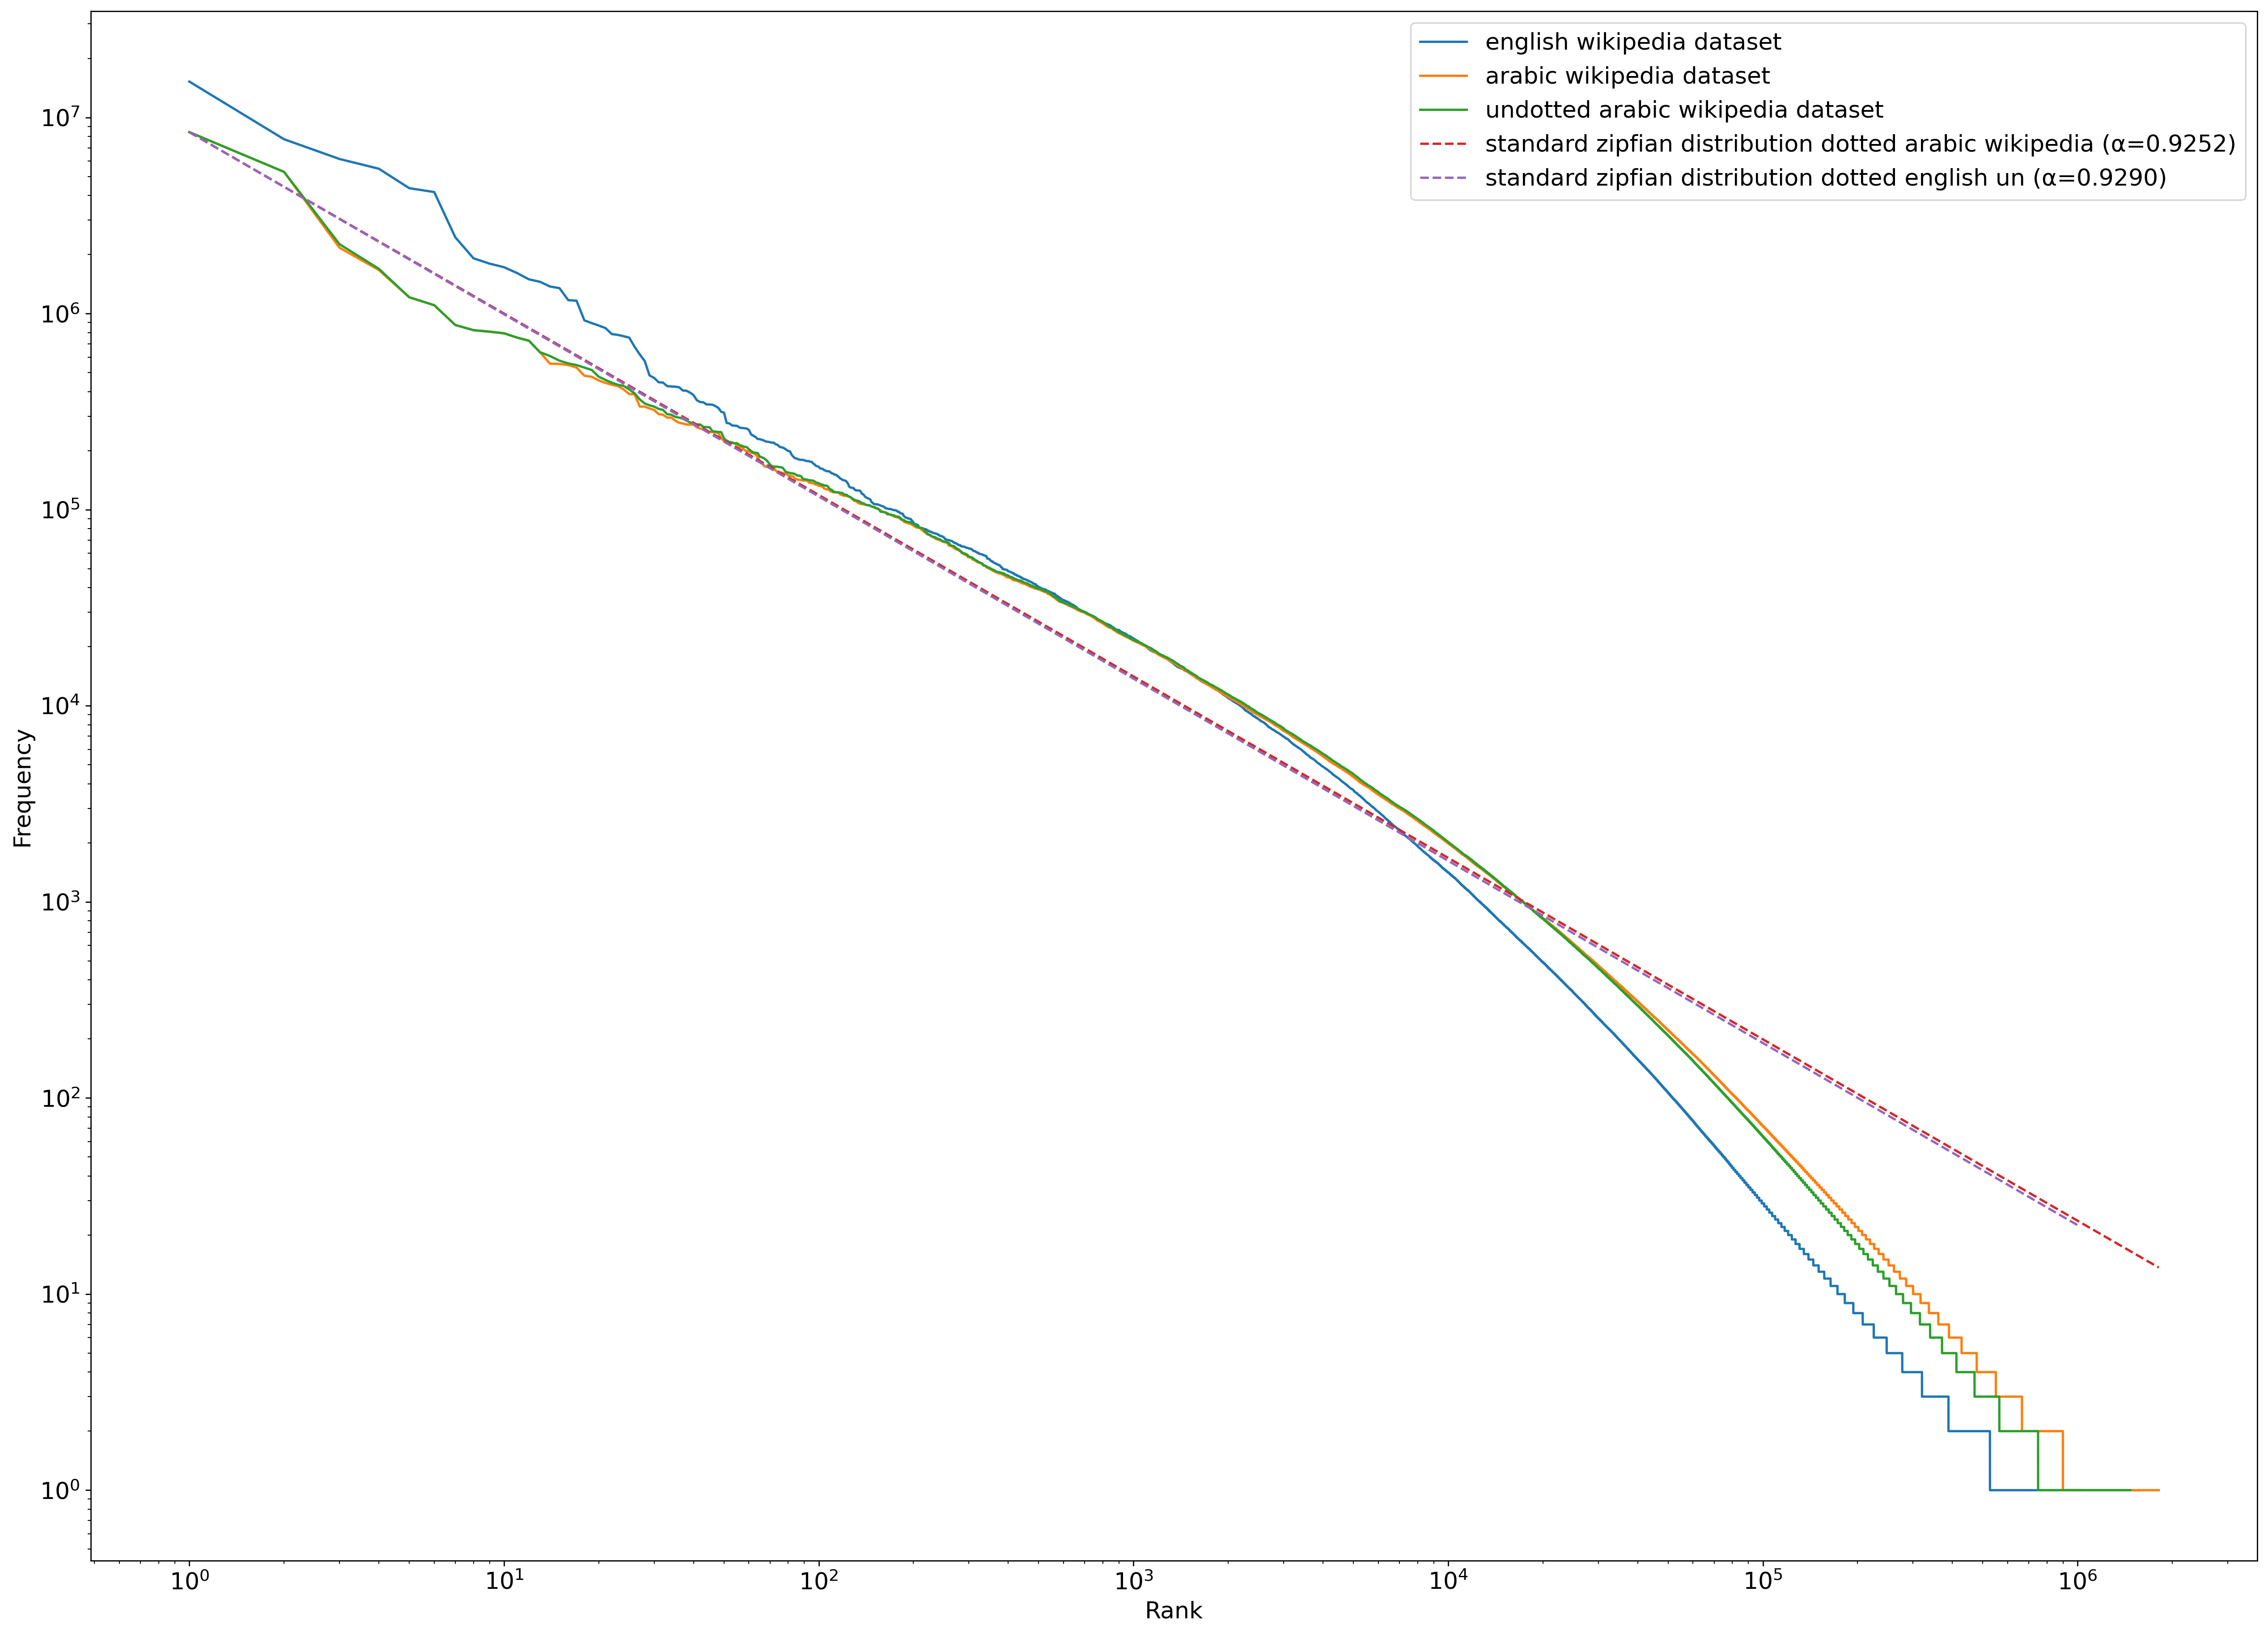

In [17]:
plot_zipf()

In [18]:
def plot_heaps(figsize=(25, 18),fontsize=15):
    unlog = lambda points: list(map(lambda point: 10**point, points))

    plt.figure(figsize=figsize,dpi=250)

    for i, dataset_name in enumerate(("english_wiki", "arabic_wiki", "undotted_arabic_wiki")):
        X, Y = (
            globals()[f"{dataset_name}_heaps_X"],
            globals()[f"{dataset_name}_heaps_Y"],
        )

        k, b = (
            globals()[f"{dataset_name}_heaps_k"],
            globals()[f"{dataset_name}_heaps_beta"],
        )

        plt.plot(unlog(X), unlog(Y), label=f"{dataset_name} dataset (k={k:.3f},β={b:.3f})")
        # https://stackoverflow.com/a/41308516/4412324
        # plt.text(
        #     x=0.50,
        #     y=(-i * 0.02 + 0.95),
        #     s=f"{dataset_name}: k={k:.3f},β={b:.3f}",
        #     transform=plt.gca().transAxes,
        #     fontsize=12,
        # )
    
    plt.xlabel("Running Text (N)", fontsize=fontsize)
    plt.ylabel("Vocabulary (V)", fontsize=fontsize)
    
    plt.legend(loc="upper left")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.rc("font", size=fontsize)

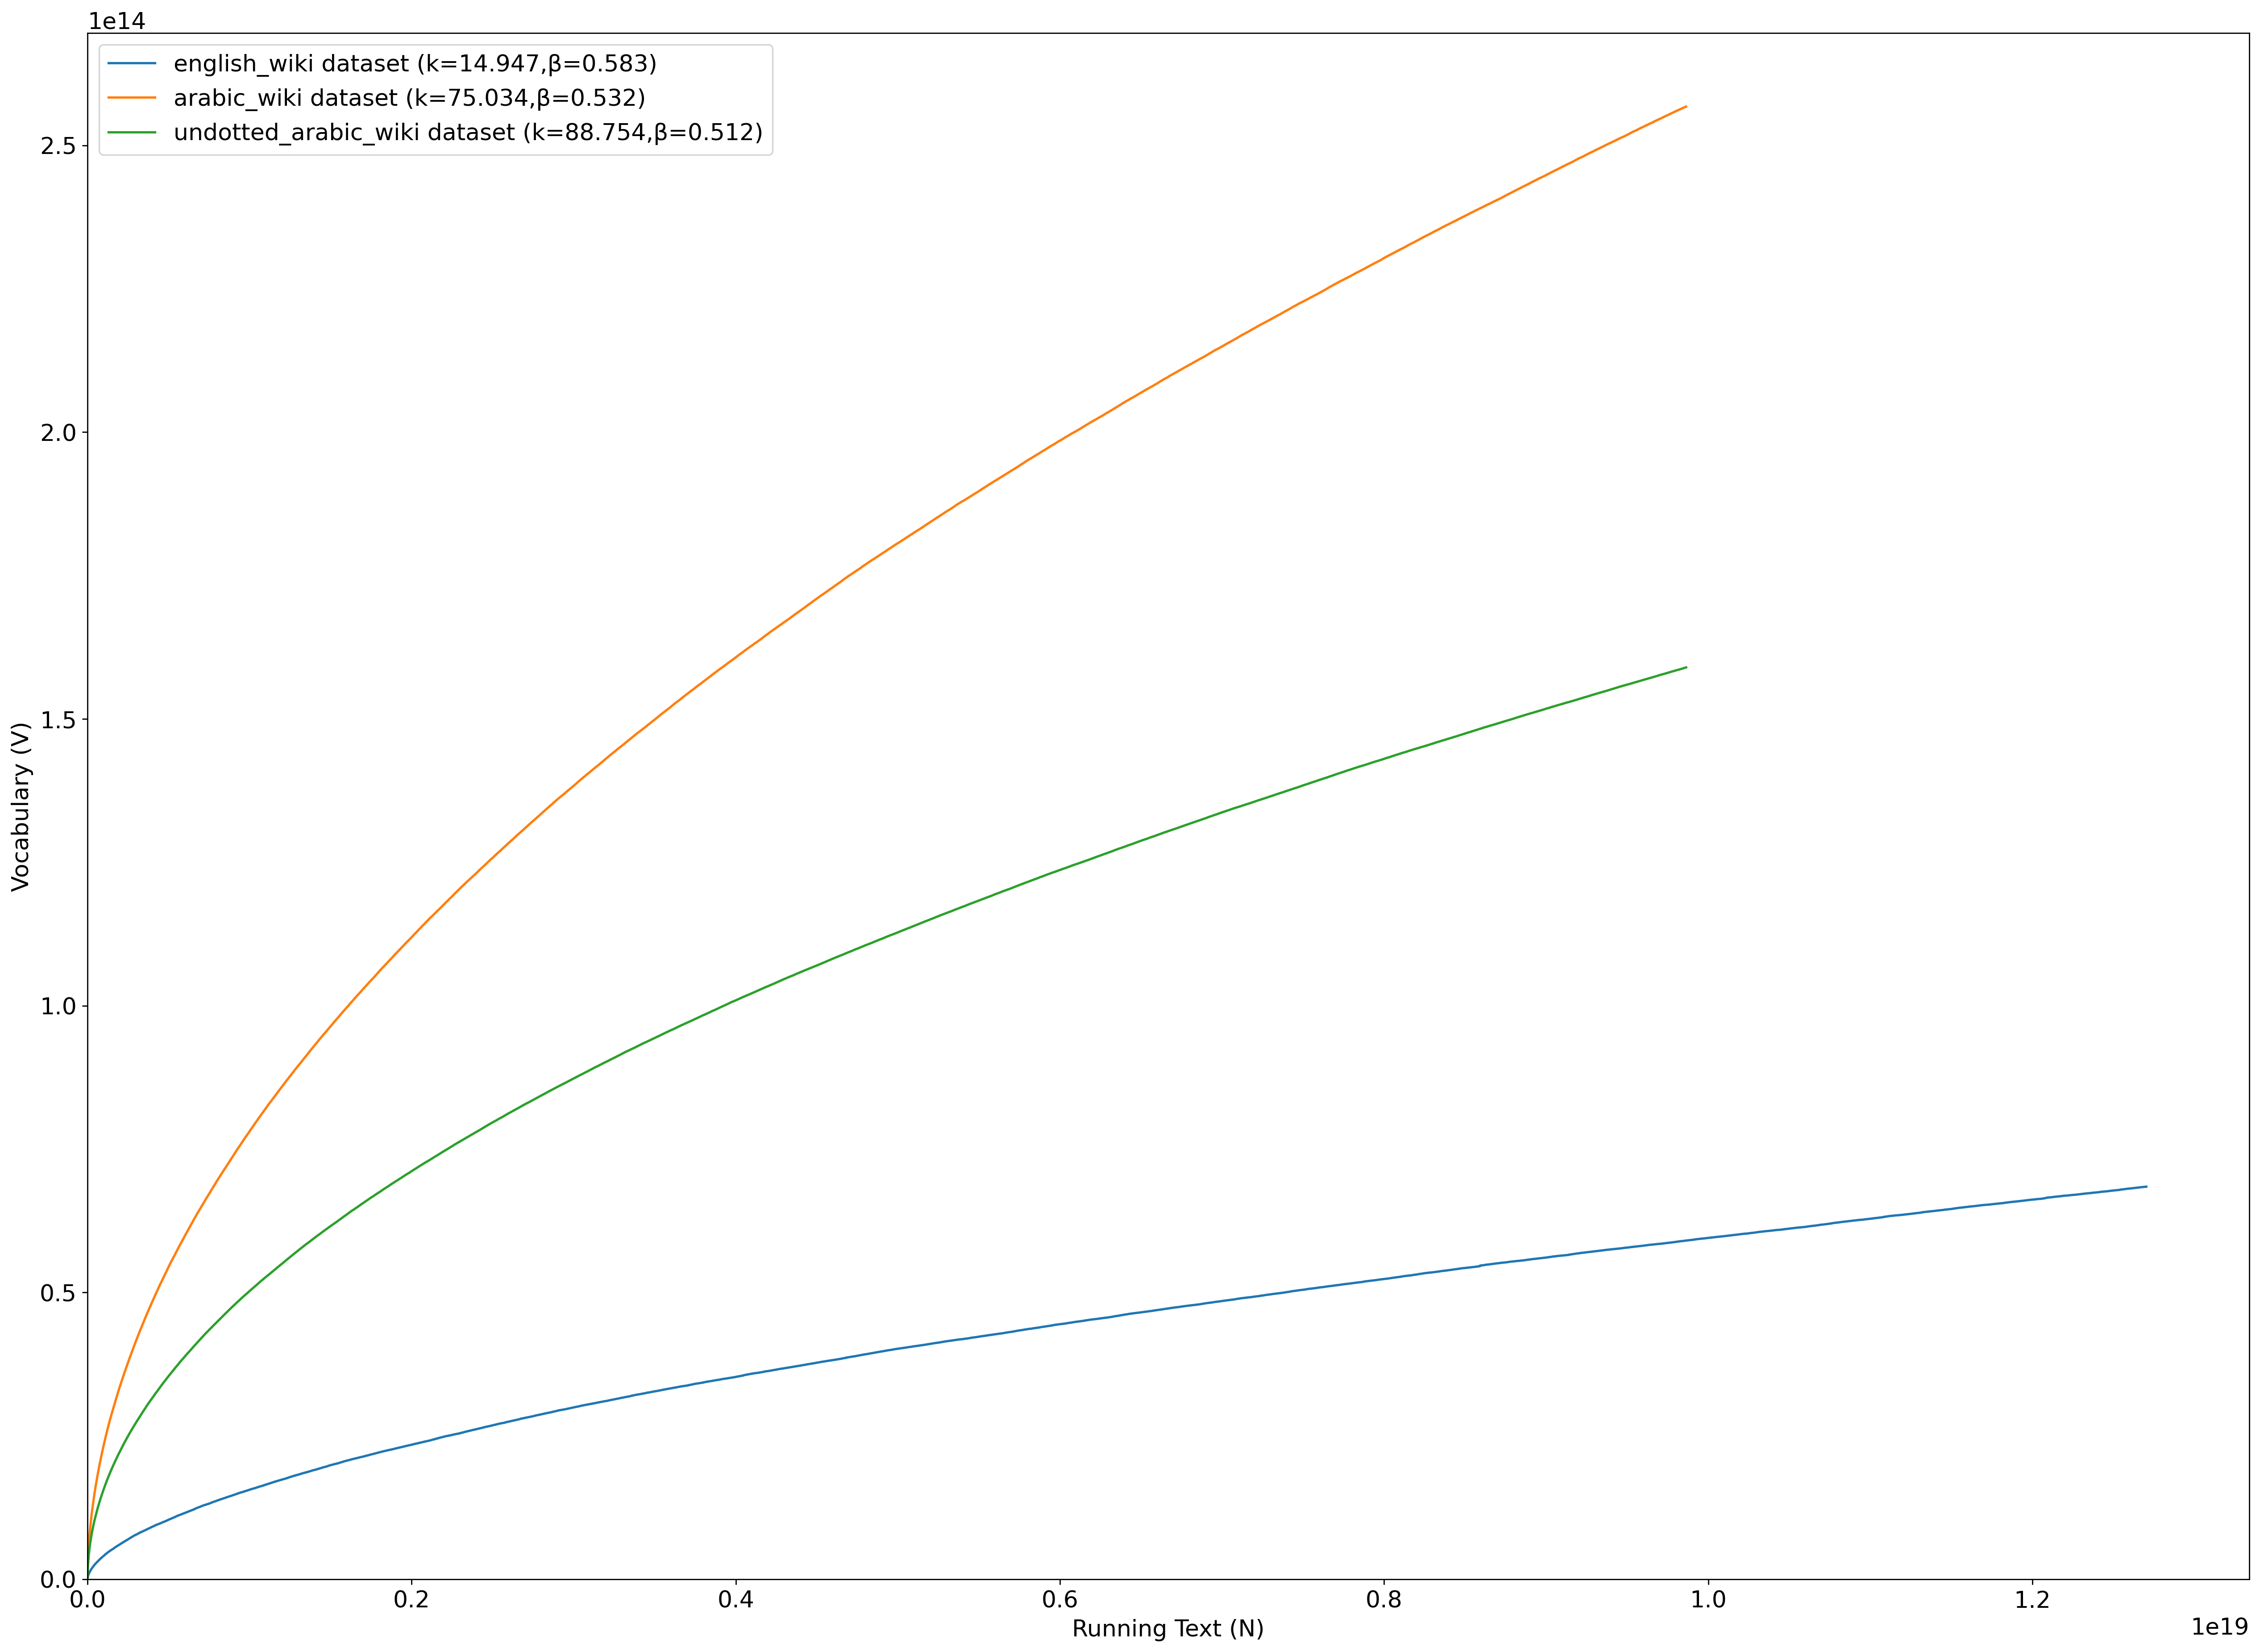

In [19]:
plot_heaps()